# 2.1: Monte Carlo Simulation under Heston Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import pandas as pd

In [3]:

class Heston:
    def __init__(self, S0, K, T, r, v0, theta, kappa, sigma, rho, Nsim, Nt, dt, discretization):
        """
        Initialize parameters for the Heston model simulation.

        Parameters:
        - S0: float, initial asset price
        - K: float, strike price (not used in path generation)
        - T: float, time to maturity
        - r: float, risk-free rate
        - v0: float, initial variance
        - theta: float, long-term mean of variance
        - kappa: float, speed of mean reversion
        - sigma: float, volatility of volatility
        - rho: float, correlation between asset and variance Brownian motions
        - Nsim: int, number of simulation paths
        - Nt: int, number of time steps
        - dt: float, time step size
        - discretization: str, either 'Euler' or 'Milstein'
        """
        self.S0 = S0 # initial stockprice
        self.K = K # stock price of the option
        self.T = T # time to maturity, in years
        self.r = r # interest rate
        self.v0 = v0 # starting volatility
        self.theta = theta # long term mean of volatility
        self.kappa = kappa # mean reversion speed
        self.sigma = sigma # volatility of volatility
        self.rho = rho # correlation between stock price and volatility
        self.Nsim = Nsim # simulation amount
        self.Nt = Nt # number of timesteps
        self.dt = dt
        self.discretization = discretization
        self.seed = 200
        self.parallel = False
    
    def geometric(self, i, W2, S):
        """
        Simulate one time step of the parallel GBM path (Black–Scholes model)
        using Brownian increments W2 from the Heston model.

        Parameters:
        - i: current time step (int)
        - W2: standard normal increments for this step (array of shape (Nsim,))
        - S: 2D array of shape (Nsim, Nt+1) for storing GBM paths
        """
        drift = (self.r - 0.5 * self.theta) * self.dt
        diffusion = np.sqrt(self.theta) * np.sqrt(self.dt) * W2

        return S[:, i - 1] * np.exp(drift + diffusion)



    def simulate(self):
        """
        Simulate asset and variance paths under the Heston model using either Euler or Milstein discretization.

        Returns:
        - S: ndarray of shape (Nsim, Nt+1), simulated asset price paths
        - v: ndarray of shape (Nsim, Nt+1), simulated variance paths (kept non-negative)
        """
        np.random.seed(self.seed)
        S = np.zeros((self.Nsim, self.Nt + 1))
        S[:, 0] = self.S0
        v = np.zeros((self.Nsim, self.Nt + 1))
        v[:, 0] = self.v0

        if self.parallel == True:
            S_parallel = np.zeros((self.Nsim, self.Nt + 1))
            S_parallel[:, 0] = self.S0


        Z1 = np.random.standard_normal((self.Nsim, self.Nt))
        Z2 = np.random.standard_normal((self.Nsim, self.Nt))

        for i in range(1, self.Nt + 1):
            W1 = Z1[:, i - 1]
            W2 = self.rho * W1 + np.sqrt(1 - self.rho**2) * Z2[:, i - 1]

            if self.discretization == 'Euler':
                v[:, i] = np.maximum(
                    v[:, i-1] + self.kappa * (self.theta - v[:, i-1]) * self.dt +
                    self.sigma * np.sqrt(np.maximum(v[:, i-1], 0)) * np.sqrt(self.dt) * W1, 0
                )
                S[:, i] = S[:, i-1] * np.exp(
                    (self.r - 0.5 * v[:, i-1]) * self.dt +
                    np.sqrt(np.maximum(v[:, i-1], 0)) * np.sqrt(self.dt) * W2
                )

                if self.parallel == True: 
                    S_parallel[:, i] = self.geometric(i, W2, S_parallel)


            elif self.discretization == 'Milstein':
                v[:, i] = np.maximum(
                    v[:, i-1] + self.kappa * (self.theta - v[:, i-1]) * self.dt +
                    self.sigma * np.sqrt(np.maximum(v[:, i-1], 0)) * np.sqrt(self.dt) * W1 +
                    0.25 * self.sigma**2 * self.dt * (W1**2 - 1), 0
                )
                S[:, i] = S[:, i-1] * np.exp(
                    (self.r - 0.5 * v[:, i-1]) * self.dt +
                    np.sqrt(np.maximum(v[:, i-1], 0)) * np.sqrt(self.dt) * W2
                )

                if self.parallel == True:
                    S_parallel[:, i] = self.geometric(i, W2, S_parallel)
        
        if self.parallel == True:
            return S, v, S_parallel
        else:
            return S, v
    
    def monte_carlo_pricing_estimator(self, matrix):
        """
        Estimate the price of an Asian call option using Monte Carlo simulation.

        Parameters:
        - matrix: ndarray, simulated asset price paths (shape: Nsim x (Nt+1))

        Returns:
        - asian_call_price_monte_carlo: float, estimated option price
        - std_error: float, standard error of the estimate
        """
        # Compute arithmetic average price along each simulation path (excluding initial price)
        average_arith = np.mean(matrix[:, 1:], axis=1)

        # Compute raw (undiscounted) Asian call payoffs
        raw_payoffs = np.maximum(average_arith - self.K, 0)

        # Average the payoffs
        expected_payoff = np.mean(raw_payoffs)

        # Discount to present value
        asian_call_price_monte_carlo = np.exp(-self.r * self.T) * expected_payoff

        # Standard error (also discount the std of raw payoffs)
        std_error = ( np.std(raw_payoffs, ddof=1) / np.sqrt(self.Nsim)  ) * np.exp(-self.r * self.T)

        return asian_call_price_monte_carlo, raw_payoffs, std_error

    def compute_control_variate_components(self, S_heston, S_gbm):
        # Exclude initial price
        S_gbm_avg_geom = np.exp(np.mean(np.log(S_gbm[:, 1:]), axis=1))

        # Raw payoffs
        raw_payoff_gbm = np.maximum(S_gbm_avg_geom - self.K, 0)

        # Averages (before discounting)
        avg_gbm = np.mean(raw_payoff_gbm)

        # Discounted price estimates
        X_bar = np.exp(-self.r * self.T) * avg_gbm

        # Standard errors (not discounted)
        stderr_X = (np.std(raw_payoff_gbm, ddof=1) / np.sqrt(len(raw_payoff_gbm))) * np.exp(-self.r * self.T)

        # Analytical geometric Asian price (use constant sigma = sqrt(theta))
        C_g = self.geometric_asian_call_analytic(self.S0, self.K, self.r, np.sqrt(self.theta), self.T, self.Nt)

        return  X_bar, C_g, stderr_X, raw_payoff_gbm


    def compute_C_cv(self, Y_bar, X_bar, C_g, payoff_heston, payoff_gbm, c):
        C_cv = Y_bar + c * (C_g - X_bar)

        # Sample covariance and variances
        cov = np.cov(payoff_heston, payoff_gbm, ddof=1)[0, 1]
        var_Y = np.var(payoff_heston, ddof=1)
        var_X = np.var(payoff_gbm, ddof=1)

        N = len(payoff_heston)
        var_C_cv = var_Y + c**2 * var_X - 2 * c * cov
        stderr_C_cv = np.sqrt(var_C_cv / N) * np.exp(-self.r * self.T)

        return C_cv, stderr_C_cv
    
    def compute_C_cv_optimal(self, payoff_heston, payoff_gbm):
        cov = np.cov(payoff_heston, payoff_gbm, ddof=1)[0, 1]
        var_X = np.var(payoff_gbm, ddof=1)
        c_opt = cov / var_X
        return c_opt


    def geometric_asian_call_analytic(self, S0, K, r, sigma, T, N):
        """
        Closed-form solution for geometric-average Asian call under Black-Scholes.
        
        Parameters:
        - S0: float, initial stock price
        - K: float, strike price
        - r: float, risk-free interest rate
        - sigma: float, volatility
        - T: float, time to maturity
        - N: int, number of monitoring points (e.g., 252 for daily)

        Returns:
        - price: float, the analytical price of the geometric Asian call
        """

        sigma_tilde = sigma * np.sqrt((2 * N + 1) / (6 * (N + 1)))
        r_tilde = 0.5 * ((r - 0.5 * sigma**2) + (sigma_tilde**2))

        d1 = (np.log(S0 / K) + (r_tilde + 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
        d2 = (np.log(S0 / K) + (r_tilde - 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))

        # Final price
        price = S0 * np.exp((r_tilde -r) * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return price





# Task 1 Graphs

3.0079333878595507


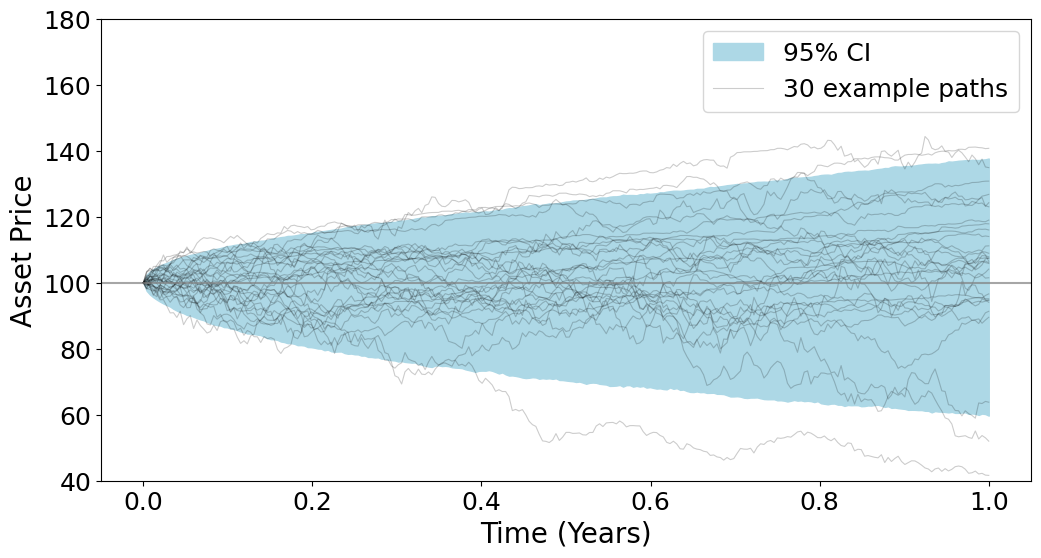

In [11]:
euler_model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                         kappa=2.0, sigma=0.5, rho=-0.7,
                         Nsim=10000, Nt=252, dt=1/252, discretization='Euler')
S, V = euler_model.simulate()
print(euler_model.monte_carlo_pricing_estimator(S)[0])
# Time vector for plotting
t = np.linspace(0, euler_model.T, euler_model.Nt + 1)

# Compute 95% confidence interval (2.5th and 97.5th percentiles)
lower = np.percentile(S, 2.5, axis=0)
upper = np.percentile(S, 97.5, axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.fill_between(t, lower, upper, color='Lightblue', label='95% CI')
for i in range(30):  # Plot first 30 paths in black
    label = "30 example paths" if i == 1 else None
    plt.plot(t, S[i], color='black', linewidth=0.8, alpha=0.2, label=label)

plt.ylim(40,180)
# plt.title("Heston Model Asset Paths with 95% Confidence Interval")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Time (Years)", fontsize = 20)
plt.ylabel("Asset Price", fontsize = 20)
plt.legend(fontsize=18)
plt.axhline(100, color='gray', alpha = 0.7)
plt.show()


2.988723506839336


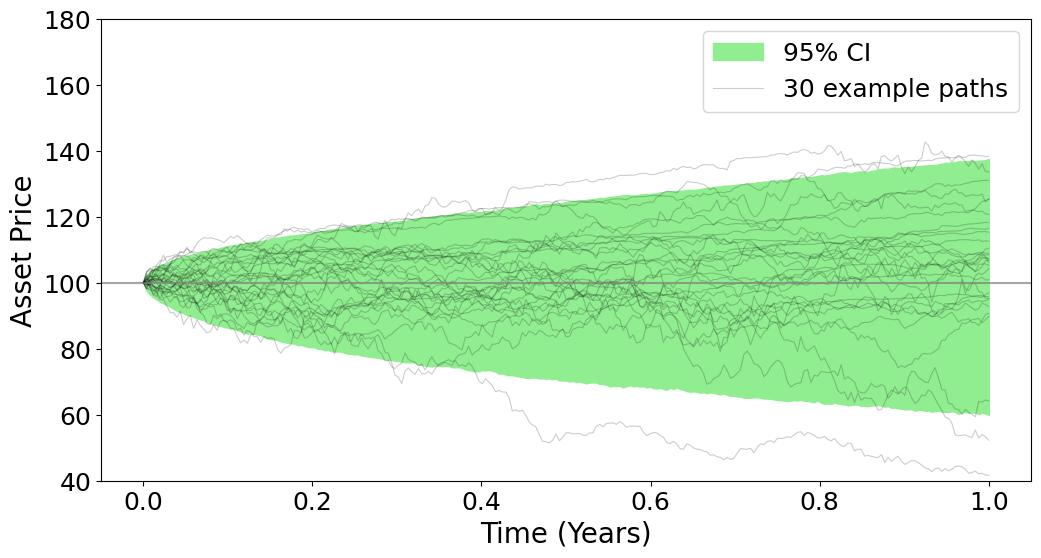

In [12]:
euler_model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                         kappa=2.0, sigma=0.5, rho=-0.7,
                         Nsim=10000, Nt=252, dt=1/252, discretization='Milstein')
S, V = euler_model.simulate()
print(euler_model.monte_carlo_pricing_estimator(S)[0])
# Time vector for plotting
t = np.linspace(0, euler_model.T, euler_model.Nt + 1)

# Compute 95% confidence interval (2.5th and 97.5th percentiles)
lower = np.percentile(S, 2.5, axis=0)
upper = np.percentile(S, 97.5, axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.fill_between(t, lower, upper, color='Lightgreen', label='95% CI')
for i in range(30):  # Plot first 30 paths in black
    label = "30 example paths" if i == 1 else None
    plt.plot(t, S[i], color='black', linewidth=0.8, alpha=0.2, label=label)

plt.ylim(40,180)
# plt.title("Heston Model Asset Paths with 95% Confidence Interval")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Time (Years)", fontsize = 20)
plt.ylabel("Asset Price", fontsize = 20)
plt.legend(fontsize=18)
plt.axhline(100, color='gray', alpha = 0.7)
plt.show()

3.475414288285448


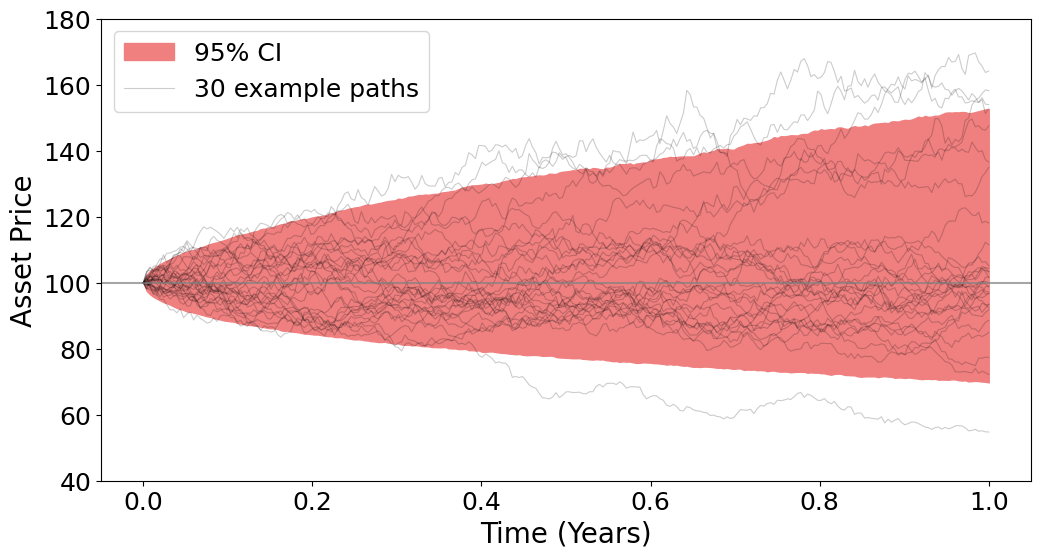

In [13]:
euler_model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                         kappa=2.0, sigma=0.5, rho=-0.7,
                         Nsim=10000, Nt=252, dt=1/252, discretization='Milstein')
euler_model.parallel = True
_,_,S = euler_model.simulate()
print(euler_model.monte_carlo_pricing_estimator(S)[0])
# Time vector for plotting
t = np.linspace(0, euler_model.T, euler_model.Nt + 1)

# Compute 95% confidence interval (2.5th and 97.5th percentiles)
lower = np.percentile(S, 2.5, axis=0)
upper = np.percentile(S, 97.5, axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.fill_between(t, lower, upper, color='Lightcoral', label='95% CI')
for i in range(30):  # Plot first 30 paths in black
    label = "30 example paths" if i == 1 else None
    plt.plot(t, S[i], color='black', linewidth=0.8, alpha=0.2, label=label)

plt.ylim(40,180)
# plt.title("Heston Model Asset Paths with 95% Confidence Interval")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Time (Years)", fontsize = 20)
plt.ylabel("Asset Price", fontsize = 20)
plt.legend(fontsize=18)
plt.axhline(100, color='gray', alpha = 0.7)
plt.show()

In [377]:
# TEST
euler_model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                         kappa=2.0, sigma=0, rho=-0.7,
                         Nsim=100000, Nt=252, dt=1/252, discretization='Milstein')
euler_model.parallel = True 
S, _, S_gbm= euler_model.simulate()

price1, _, _ = euler_model.monte_carlo_pricing_estimator(S)
price2, _, _ = euler_model.monte_carlo_pricing_estimator(S_gbm)
price3 = euler_model.geometric_asian_call_analytic(S0=100, K=105, r=0.05, sigma=np.sqrt(0.04), T=1, N=252)

print(price1)
print(price2)
print(price3)




3.519994010904242
3.519994010904242
3.320146123263015


In [490]:
import matplotlib.pyplot as plt

# Shared vol-of-vol values
# sigma_vals = [0, 0.5, 1, 1.5, 2, 2.5, 3]
sigma_vals = np.arange(0, 2.0125, 0.0125)

# Containers for both methods
euler_means, euler_std_errors = [], []
milstein_means, milstein_std_errors = [], []

# Run for each σ
for v_of_v in sigma_vals:
    # Euler
    euler_model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                         kappa=2.0, sigma=v_of_v, rho=-0.7,
                         Nsim=10000, Nt=252, dt=1/252, discretization='Euler')
    s_euler, _ = euler_model.simulate()
    mean_euler, payoff_euler, se_euler = euler_model.monte_carlo_pricing_estimator(s_euler)
    euler_means.append(mean_euler)
    euler_std_errors.append(se_euler)

    # Milstein
    milstein_model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                         kappa=2.0, sigma=v_of_v, rho=-0.7,
                         Nsim=10000, Nt=252, dt=1/252, discretization='Milstein')
    s_milstein, _ = milstein_model.simulate()
    mean_milstein, payoff_milstein, se_milstein = milstein_model.monte_carlo_pricing_estimator(s_milstein)
    milstein_means.append(mean_milstein)
    milstein_std_errors.append(se_milstein)

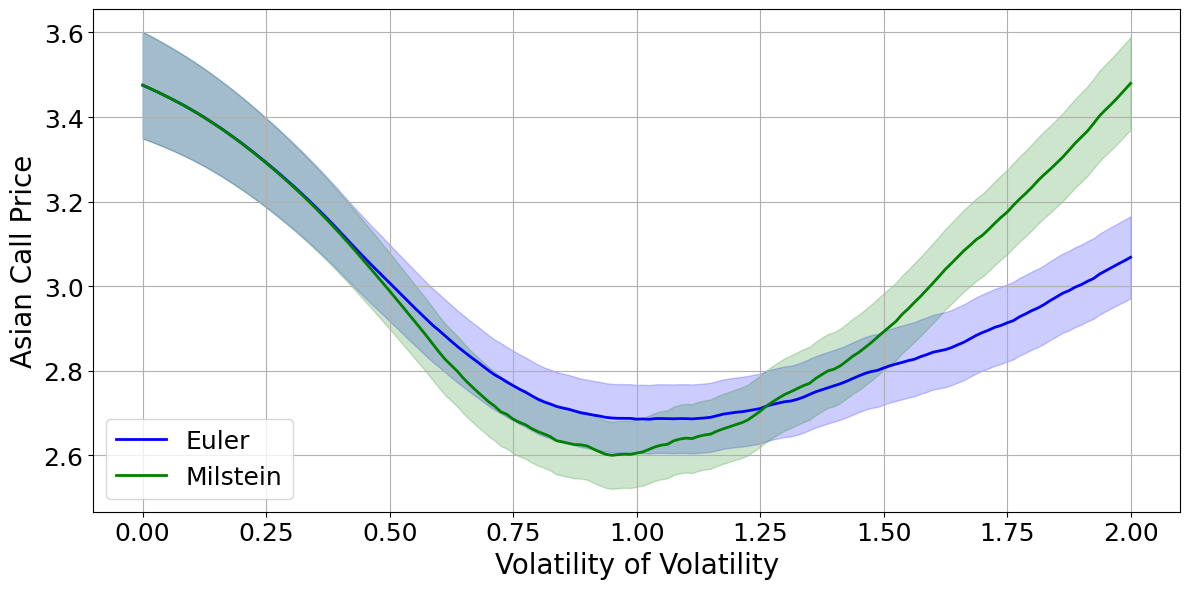

In [495]:
plt.figure(figsize=(12, 6))

# Convert to arrays for vector operations
sigma_vals = np.array(sigma_vals)
euler_means = np.array(euler_means)
euler_std_errors = np.array(euler_std_errors)
milstein_means = np.array(milstein_means)
milstein_std_errors = np.array(milstein_std_errors)

# Plot means
plt.plot(sigma_vals, euler_means, label='Euler', color='blue', linewidth=2)
plt.plot(sigma_vals, milstein_means, label='Milstein', color='green', linewidth=2)

# Fill ±1 standard error band
plt.fill_between(sigma_vals, euler_means - euler_std_errors*1.96, euler_means + euler_std_errors*1.96,
                 color='blue', alpha=0.2)
plt.fill_between(sigma_vals, milstein_means - milstein_std_errors*1.96, milstein_means + milstein_std_errors*1.96,
                 color='green', alpha=0.2)

# Labels and formatting
plt.xlabel('Volatility of Volatility', fontsize=20)
plt.ylabel('Asian Call Price', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
# plt.ylim(2.5,3.5)
# plt.xlim(0,0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

vragen: 
1. moet ik option payoff gebruiken of the call price en wat is a known or approximated benchmark?
2. wat is een justified sigma
3. Wat is test op known scenarios?

In [ ]:
model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                         kappa=2.0, sigma=v_of_v, rho=-0.7,
                         Nsim=10000, Nt=252, dt=1/252, discretization='Euler')
model.parallel = True
S_heston, _ , S_geometric = model.simulate()
Y_bar, X_bar, C_g, stderr_Y, stderr_X, payoff_heston, payoff_gbm = model.compute_control_variate_components(S_heston, S_geometric)
c_opt = model.compute_C_cv_optimal(payoff_heston, payoff_gbm)
C_cv, stderr_C_cv = model.compute_C_cv(Y_bar, X_bar, C_g, payoff_heston, payoff_gbm, c=c_opt)

print("Asian Call Option Pricing with Control Variate (Heston Model)")
print("-------------------------------------------------------------")
print(f"Arithmetic Asian (Heston) Price Estimate:     {Y_bar:.4f} ± {stderr_Y:.4f}")
print(f"Geometric Asian (GBM) Price Estimate:         {X_bar:.4f} ± {stderr_X:.4f}")
print(f"Analytical Geometric Asian (GBM) Price:       {C_g:.4f}")
print()
print(f"Control Variate Estimate (c={c_opt:.4f}): {C_cv:.4f} ± {stderr_C_cv:.4f}")

# Task 2

In [149]:
def geometric_asian_call_analytic(S0, K, r, sigma, T, N):
    """
    Closed-form solution for geometric-average Asian call under Black-Scholes.
    
    Parameters:
    - S0: float, initial stock price
    - K: float, strike price
    - r: float, risk-free interest rate
    - sigma: float, volatility
    - T: float, time to maturity
    - N: int, number of monitoring points (e.g., 252 for daily)

    Returns:
    - price: float, the analytical price of the geometric Asian call
    """

    sigma_tilde = sigma * np.sqrt((2 * N + 1) / (6 * (N + 1)))
    r_tilde = 0.5 * ((r - 0.5 * sigma**2) + (0.5 * sigma_tilde**2))

    d1 = (np.log(S0 / K) + (r_tilde + 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r_tilde - 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))

    # Final price
    price = S0 * np.exp((r_tilde -r) * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price
    

In [150]:
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
N = 252

# Plug into your function
price = geometric_asian_call_analytic(S0, K, r, sigma, T, N)
price

5.350853645168478

todo: justify die volatility and test with what?


# Task 3

In [381]:
model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                         kappa=2.0, sigma=0.5, rho=-0.7,
                         Nsim=10000, Nt=252, dt=1/252, discretization='Milstein')
model.parallel = True
S_heston, _ , S_geometric = model.simulate()
Y_bar, payoff_heston, std_error_Y_bar = model.monte_carlo_pricing_estimator(S_heston)
X_bar, C_g, stderr_X, payoff_gbm = model.compute_control_variate_components(S_heston, S_geometric)
c_opt = model.compute_C_cv_optimal(payoff_heston, payoff_gbm)
C_cv, stderr_C_cv = model.compute_C_cv(Y_bar, X_bar, C_g, payoff_heston, payoff_gbm, c=c_opt)


print("Asian Call Option Pricing with Control Variate (Heston Model)")
print("-------------------------------------------------------------")
print(f"Arithmetic Asian (Heston) Price Estimate:     {Y_bar} ± {std_error_Y_bar:.4f}")
print(f"Geometric Asian (GBM) Price Estimate:         {X_bar:.4f} ± {stderr_X:.4f}")
print(f"Analytical Geometric Asian (GBM) Price:       {C_g:.4f}")
print()
print(f"Control Variate Estimate (c={c_opt:.4f}): {C_cv:.4f} ± {stderr_C_cv:.4f}")
print()











Asian Call Option Pricing with Control Variate (Heston Model)
-------------------------------------------------------------
Arithmetic Asian (Heston) Price Estimate:     2.988723506839336 ± 0.0459
Geometric Asian (GBM) Price Estimate:         3.2934 ± 0.0646
Analytical Geometric Asian (GBM) Price:       3.3201

Control Variate Estimate (c=0.5959): 3.0047 ± 0.0277



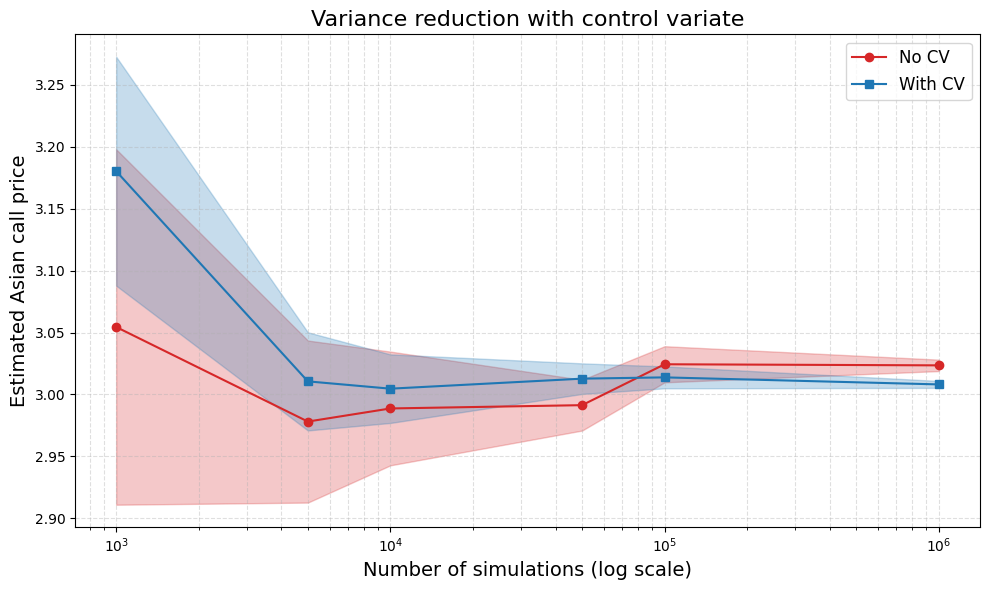

In [ ]:
# simulation sizes
sim_sizes = [100, 1000, 5000, 10_000, 50_000, 100_000,1_000_000]

# storage
n_list        = []
est_no_cv     = []
stderr_no_cv  = []
est_cv        = []
stderr_cv     = []

for Nsim in sim_sizes:
    model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                   kappa=2.0, sigma=0.5, rho=-0.7,
                   Nsim=Nsim, Nt=252, dt=1/252, discretization='Milstein')
    model.parallel = True
    
    S_heston, _, S_geo = model.simulate()
    
    # mc
    Y_bar, payoff_heston, se_Y = model.monte_carlo_pricing_estimator(S_heston)
    
    # cv
    X_bar, C_g, _, payoff_gbm = model.compute_control_variate_components(S_heston, S_geo)
    c_opt  = model.compute_C_cv_optimal(payoff_heston, payoff_gbm)
    C_cv, se_cv = model.compute_C_cv(Y_bar, X_bar, C_g, payoff_heston, payoff_gbm, c=c_opt)
    
    # store
    n_list.append(Nsim)
    est_no_cv.append(Y_bar)
    stderr_no_cv.append(se_Y)
    est_cv.append(C_cv)
    stderr_cv.append(se_cv)

# plot
n_arr       = np.array(n_list, dtype=float)
est_no_cv   = np.array(est_no_cv)
se_no_cv    = np.array(stderr_no_cv)
est_cv      = np.array(est_cv)
se_cv       = np.array(stderr_cv)




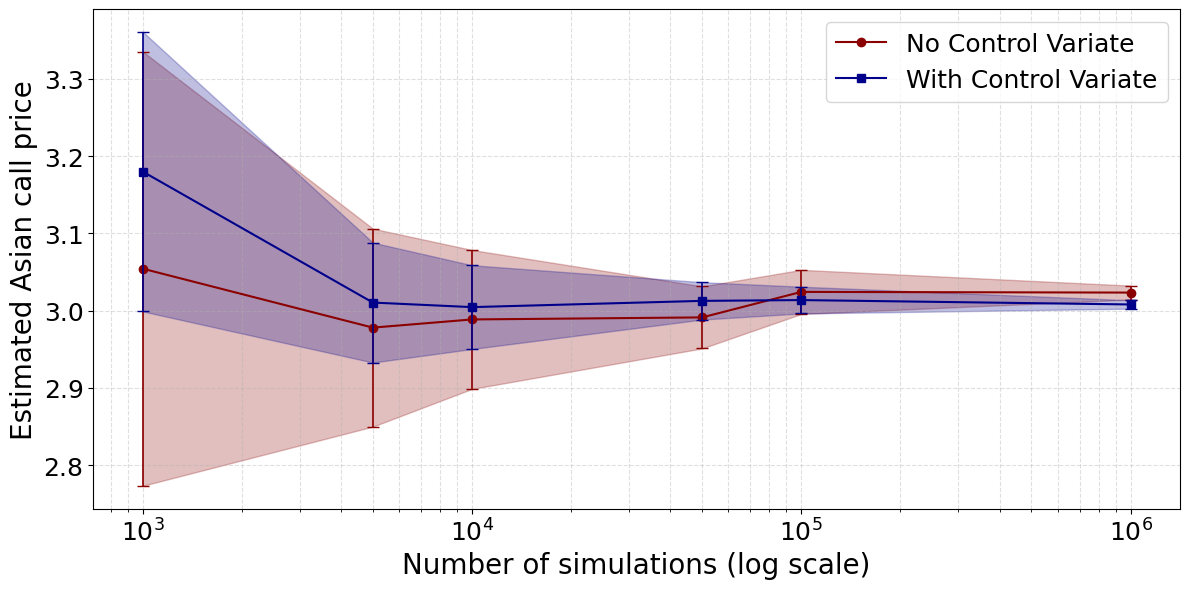

In [ ]:
width = 1.96        

plt.figure(figsize=(12,6))

# without cv
plt.plot(n_arr, est_no_cv, marker='o', color='darkred',  label='No Control Variate')
plt.fill_between(n_arr,
                 est_no_cv - width*se_no_cv,
                 est_no_cv + width*se_no_cv,
                 color='darkred', alpha=0.25)
plt.errorbar(n_arr, est_no_cv, yerr=width * se_no_cv, fmt='none',
             ecolor='darkred', elinewidth=1.2, capsize=4)
# with cv
plt.plot(n_arr, est_cv,    marker='s', color='darkblue', label='With Control Variate')
plt.fill_between(n_arr,
                 est_cv - width*se_cv,
                 est_cv + width*se_cv,
                 color='darkblue', alpha=0.25)
plt.errorbar(n_arr, est_cv, yerr=width * se_cv, fmt='none',
             ecolor='darkblue', elinewidth=1.2, capsize=4)


plt.xscale('log')
plt.xlabel('Number of simulations (log scale)', fontsize=20)
plt.ylabel('Estimated Asian call price', fontsize=20)
# plt.title('Variance reduction with control variate', fontsize=16)
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()




In [5]:
# Define sigma values (vol of vol)
sigma_vals = np.arange(0, 1.0125, 0.0125)

# Storage
sigma_list  = []
est_no_cv   = []
ci_lo_no_cv = []
ci_hi_no_cv = []

est_cv      = []
ci_lo_cv    = []
ci_hi_cv    = []

for sigma in sigma_vals:
    model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                   kappa=2.0, sigma=sigma, rho=-0.7,
                   Nsim=10_000, Nt=252, dt=1/252, discretization='Milstein')
    model.parallel = True

    S_heston, _, S_geo = model.simulate()
    
    # Plain Monte Carlo
    Y_bar, payoff_heston, se_Y = model.monte_carlo_pricing_estimator(S_heston)
    ci_low_Y = Y_bar - 1.96 * se_Y
    ci_high_Y = Y_bar + 1.96 * se_Y

    # Control variate
    X_bar, C_g, _, payoff_gbm = model.compute_control_variate_components(S_heston, S_geo)
    c_opt = model.compute_C_cv_optimal(payoff_heston, payoff_gbm)
    C_cv, se_cv = model.compute_C_cv(Y_bar, X_bar, C_g, payoff_heston, payoff_gbm, c=c_opt)
    ci_low_cv = C_cv - 1.96 * se_cv
    ci_high_cv = C_cv + 1.96 * se_cv

    # Store results
    sigma_list.append(sigma)
    est_no_cv.append(Y_bar)
    ci_lo_no_cv.append(ci_low_Y)
    ci_hi_no_cv.append(ci_high_Y)

    est_cv.append(C_cv)
    ci_lo_cv.append(ci_low_cv)
    ci_hi_cv.append(ci_high_cv)

# Convert to arrays
sigma_arr = np.array(sigma_list)
est_no_cv = np.array(est_no_cv)
ci_lo_no_cv = np.array(ci_lo_no_cv)
ci_hi_no_cv = np.array(ci_hi_no_cv)

est_cv = np.array(est_cv)
ci_lo_cv = np.array(ci_lo_cv)
ci_hi_cv = np.array(ci_hi_cv)



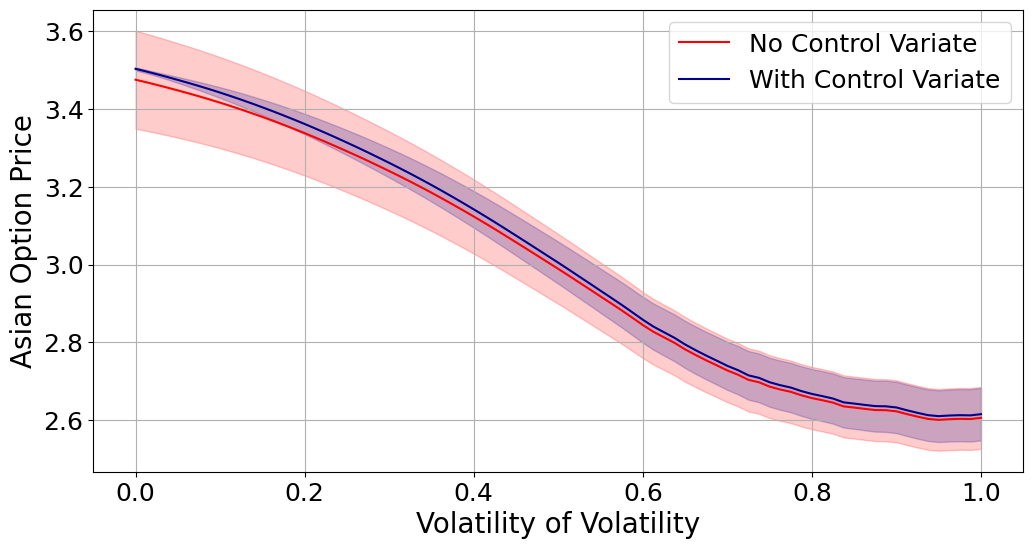

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sigma_arr, est_no_cv, label="No Control Variate", color='red')
plt.fill_between(sigma_arr, ci_lo_no_cv, ci_hi_no_cv, color='red', alpha=0.2)

plt.plot(sigma_arr, est_cv, label="With Control Variate", color='darkblue')
plt.fill_between(sigma_arr, ci_lo_cv, ci_hi_cv, color='darkblue', alpha=0.2)

plt.xlabel("Volatility of Volatility",  fontsize=20)
plt.ylabel("Asian Option Price", fontsize=20)
# plt.title("Asian Call Pricing vs. σ (with 95% Confidence Intervals)")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

In [444]:
# Define rho values from -1 to 1 in steps of 0.1
rho_vals = np.arange(-1.0, 1.0125, 0.0125)

# Storage
rho_list     = []
est_no_cv    = []
ci_lo_no_cv  = []
ci_hi_no_cv  = []

est_cv       = []
ci_lo_cv     = []
ci_hi_cv     = []

for rho in rho_vals:
    model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                   kappa=2.0, sigma=0.5, rho=rho,
                   Nsim=10_000, Nt=252, dt=1/252, discretization='Milstein')
    model.parallel = True

    S_heston, _, S_geo = model.simulate()

    # Plain Monte Carlo
    Y_bar, payoff_heston, se_Y = model.monte_carlo_pricing_estimator(S_heston)
    ci_low_Y = Y_bar - 1.96 * se_Y
    ci_high_Y = Y_bar + 1.96 * se_Y

    # Control variate
    X_bar, C_g, _, payoff_gbm = model.compute_control_variate_components(S_heston, S_geo)
    c_opt = model.compute_C_cv_optimal(payoff_heston, payoff_gbm)
    C_cv, se_cv = model.compute_C_cv(Y_bar, X_bar, C_g, payoff_heston, payoff_gbm, c=c_opt)
    ci_low_cv = C_cv - 1.96 * se_cv
    ci_high_cv = C_cv + 1.96 * se_cv

    # Store results
    rho_list.append(rho)
    est_no_cv.append(Y_bar)
    ci_lo_no_cv.append(ci_low_Y)
    ci_hi_no_cv.append(ci_high_Y)

    est_cv.append(C_cv)
    ci_lo_cv.append(ci_low_cv)
    ci_hi_cv.append(ci_high_cv)

# Convert to arrays
rho_arr      = np.array(rho_list)
est_no_cv    = np.array(est_no_cv)
ci_lo_no_cv  = np.array(ci_lo_no_cv)
ci_hi_no_cv  = np.array(ci_hi_no_cv)

est_cv       = np.array(est_cv)
ci_lo_cv     = np.array(ci_lo_cv)
ci_hi_cv     = np.array(ci_hi_cv)

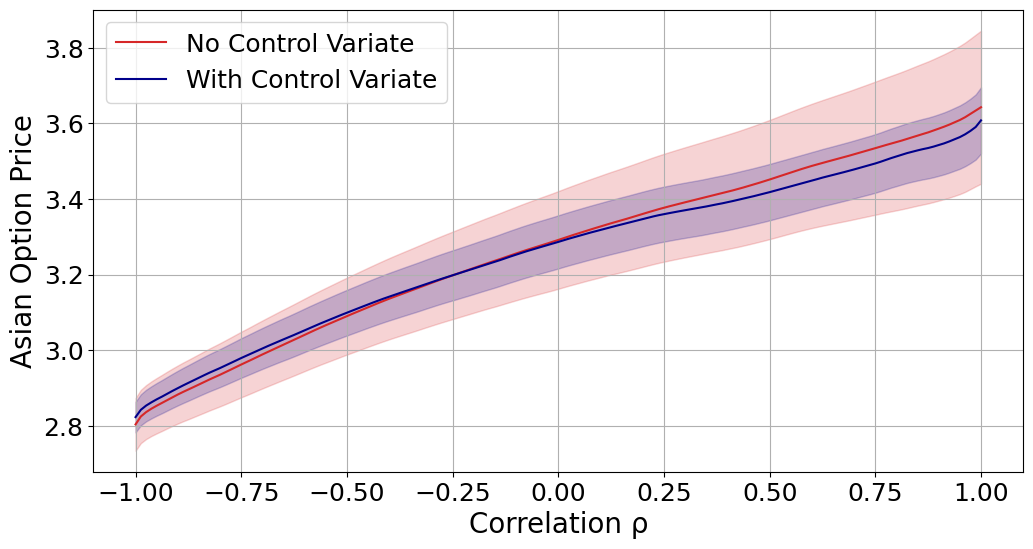

In [445]:
plt.figure(figsize=(12, 6))
plt.plot(rho_arr, est_no_cv, label="No Control Variate", color='tab:red')
plt.fill_between(rho_arr, ci_lo_no_cv, ci_hi_no_cv, color='tab:red', alpha=0.2)

plt.plot(rho_arr, est_cv, label="With Control Variate", color='darkblue')
plt.fill_between(rho_arr, ci_lo_cv, ci_hi_cv, color='darkblue', alpha=0.2)

plt.xlabel("Correlation ρ", fontsize=20)
plt.ylabel("Asian Option Price", fontsize=20)
# plt.title("Asian Call Pricing vs. ρ (with 95% Confidence Intervals)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.grid(True)
plt.show()

In [7]:
# Strike values: in-the-money, at-the-money, out-of-the-money
K_vals = np.arange(99, 101.125, 0.125)


# Storage
K_list       = []
est_no_cv    = []
ci_lo_no_cv  = []
ci_hi_no_cv  = []

est_cv       = []
ci_lo_cv     = []
ci_hi_cv     = []

for K in K_vals:
    model = Heston(S0=100, K=K, T=1, r=0.05, v0=0.04, theta=0.04,
                   kappa=2.0, sigma=0.5, rho=-0.7,
                   Nsim=10_000, Nt=252, dt=1/252, discretization='Milstein')
    model.parallel = True

    S_heston, _, S_geo = model.simulate()

    # Plain Monte Carlo
    Y_bar, payoff_heston, se_Y = model.monte_carlo_pricing_estimator(S_heston)
    ci_low_Y = Y_bar - 1.96 * se_Y
    ci_high_Y = Y_bar + 1.96 * se_Y

    # Control variate
    X_bar, C_g, _, payoff_gbm = model.compute_control_variate_components(S_heston, S_geo)
    c_opt = model.compute_C_cv_optimal(payoff_heston, payoff_gbm)
    C_cv, se_cv = model.compute_C_cv(Y_bar, X_bar, C_g, payoff_heston, payoff_gbm, c=c_opt)
    ci_low_cv = C_cv - 1.96 * se_cv
    ci_high_cv = C_cv + 1.96 * se_cv

    # Store results
    K_list.append(K)
    est_no_cv.append(Y_bar)
    ci_lo_no_cv.append(ci_low_Y)
    ci_hi_no_cv.append(ci_high_Y)

    est_cv.append(C_cv)
    ci_lo_cv.append(ci_low_cv)
    ci_hi_cv.append(ci_high_cv)



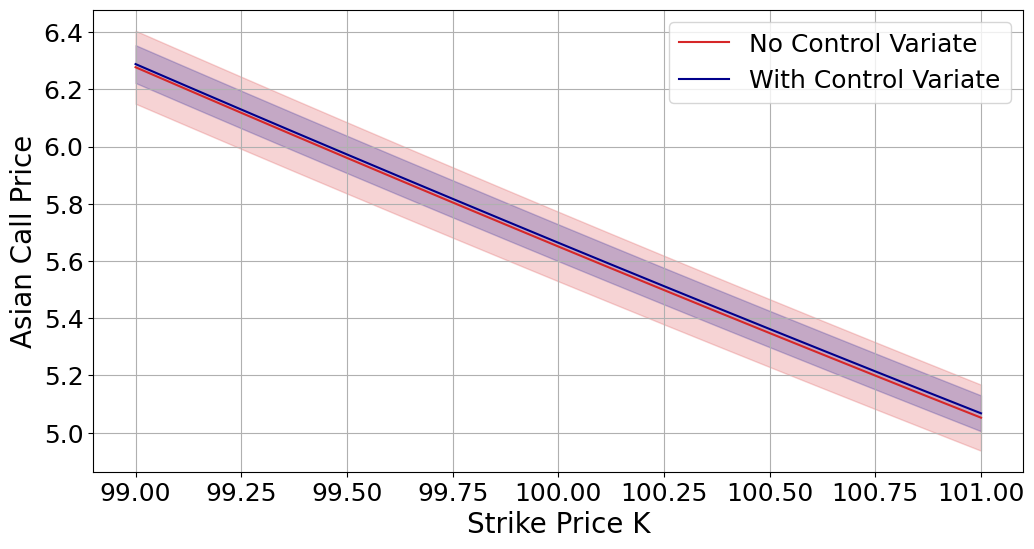

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(K_list, est_no_cv, label="No Control Variate", color='tab:red')
plt.fill_between(K_list, ci_lo_no_cv, ci_hi_no_cv, color='tab:red', alpha=0.2)

plt.plot(K_list, est_cv, label="With Control Variate", color='darkblue')
plt.fill_between(K_list, ci_lo_cv, ci_hi_cv, color='darkblue', alpha=0.2)

plt.xlabel("Strike Price K",fontsize=20)
plt.ylabel("Asian Call Price",fontsize=20)
# plt.title("Asian Call Pricing vs. Strike K (95% CI)")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.grid(True)
plt.show()

In [459]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
Nsim = 10_000
c_vals = np.arange(0, 1.005, 0.005)
width = 1.96  # for 95% confidence bands

def run_experiment(discretization):
    # Setup model
    model = Heston(S0=100, K=105, T=1, r=0.05, v0=0.04, theta=0.04,
                   kappa=2.0, sigma=0.5, rho=-0.7,
                   Nsim=Nsim, Nt=252, dt=1/252, discretization=discretization)
    model.parallel = True

    # Simulate paths
    S_heston, _, S_geo = model.simulate()

    # Monte Carlo and control variate components
    Y_bar, payoff_heston, _ = model.monte_carlo_pricing_estimator(S_heston)
    X_bar, C_g, _, payoff_gbm = model.compute_control_variate_components(S_heston, S_geo)
    c_opt = model.compute_C_cv_optimal(payoff_heston, payoff_gbm)

    C_cv_vals = []
    stderr_vals = []

    for c in c_vals:
        C_cv, stderr = model.compute_C_cv(Y_bar, X_bar, C_g, payoff_heston, payoff_gbm, c=c)
        C_cv_vals.append(C_cv)
        stderr_vals.append(stderr)

    return np.array(C_cv_vals), np.array(stderr_vals), c_opt

# Run for both Euler and Milstein
cv_euler, se_euler, copt_euler = run_experiment('Euler')
cv_milstein, se_milstein, copt_milstein = run_experiment('Milstein')





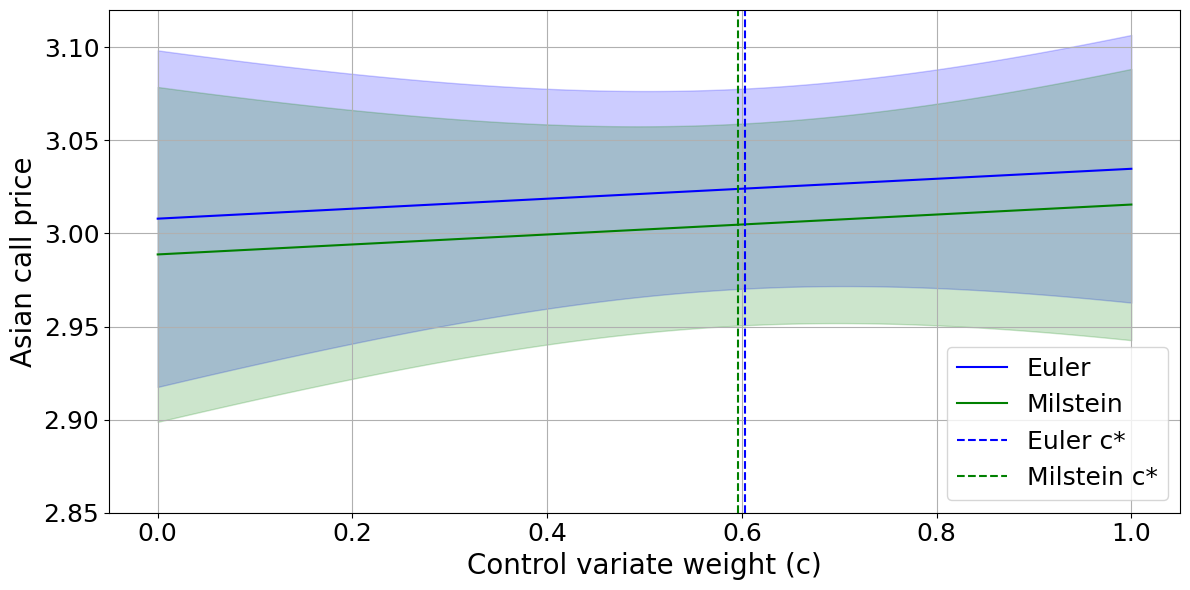

In [477]:
# Plot
plt.figure(figsize=(12, 6))

# Euler plot
plt.plot(c_vals, cv_euler, color='blue', label='Euler')
plt.fill_between(c_vals,
                 cv_euler - width * se_euler,
                 cv_euler + width * se_euler,
                 color='blue', alpha=0.2)

# Milstein plot
plt.plot(c_vals, cv_milstein, color='green', label='Milstein')
plt.fill_between(c_vals,
                 cv_milstein - width * se_milstein,
                 cv_milstein + width * se_milstein,
                 color='green', alpha=0.2)

# Optimal c vertical lines
plt.axvline(copt_euler, color='blue', linestyle='--', linewidth=1.5, label=f'Euler c*')
plt.axvline(copt_milstein, color='green', linestyle='--', linewidth=1.5, label=f'Milstein c*')

# Labels and formatting
plt.xlabel('Control variate weight (c)', fontsize=20)
plt.ylabel('Asian call price', fontsize=20)
# plt.title('Effect of control variate weight (c) on estimate (Euler vs Milstein)', fontsize=16)
plt.grid(True)
plt.ylim(2.85, 3.12)
plt.legend(fontsize=18, loc='lower right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()